In [25]:
%matplotlib inline
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from progressbar import progressbar
import scipy.stats
import statsmodels.stats.power as power
from functools import partial
import matplotlib.pyplot as plt
plt.rcParams.update({
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "black",
    "axes.facecolor": "white",
    "axes.edgecolor": "lightgray",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "lightgray",
    "figure.facecolor": "black",
    "figure.edgecolor": "black",
    "savefig.facecolor": "black",
    "savefig.edgecolor": "black"})
np.random.seed(94115)

# 1.1 Simulating basic distributions 

# 1)

In [26]:
n_obs = 10000
n = 1
p = 0.25
Xi = np.random.binomial(n, p, size=n_obs)

In [27]:
print("`Xi.mean()` = ", Xi.mean())
print("mu = ", n*p)
print("\n")
print("`Xi.std()` = ", Xi.std())
print("sigma = ", np.sqrt(n*p*(1-p)))

`Xi.mean()` =  0.2543
mu =  0.25


`Xi.std()` =  0.4354670021941961
sigma =  0.4330127018922193


In [28]:
n_obs = 10000
k = 3
Xi = np.random.exponential(k, size=n_obs)


In [29]:
print("`Xi.mean()` = ", Xi.mean())
print("mu = ", k)
print("\n")
print("`Xi.std()` = ", Xi.std())
print("sigma = ", k)

`Xi.mean()` =  2.982138336657323
mu =  3


`Xi.std()` =  3.0068122860217503
sigma =  3


# 2)

# i) 

In [33]:
def draw_one_sample_binomial(p = 0.25, n=1000):
    """Randomly generate one dataset of size n"""
    Xi = np.random.binomial(1,p, size=n)
    return Xi
def draw_one_sample_exponential(scale = 3, n=1000):
    """Randomly generate one dataset of size n"""
    Xi = np.random.exponential(scale, size=n)
    return Xi

In [34]:
b = 5000  # Total number of *samples* to generate
n = 1000  # The number of data points in each sample

sample_means_binomial = []  # We collect the 5000 Xbars here!
sample_means_exponential = []

list_of_samples_binomial = [draw_one_sample_binomial(n=n) for _ in tqdm_notebook(range(0, b))]
list_of_samples_exponential = [draw_one_sample_exponential(n=n) for _ in tqdm_notebook(range(0, b))]

sample_means_binomial = [sample.mean() for sample in list_of_samples_binomial]
sample_means_exponential = [sample.mean() for sample in list_of_samples_exponential]

sample_means_binomial = pd.Series(sample_means_binomial)
sample_means_exponential = pd.Series(sample_means_exponential)

In [40]:
sample_means_binomial.mean()
sample_means_exponential.mean()

print("The simulated Xbar values have the expected theoretical distribution:")
print("Simulated mean of Xbar for binomial distribution", sample_means_binomial.mean())
print("Theoretical expectation of Xbar for binomial distribution",0.25)
print("Simulated standard deviation of Xbar for binomial distribution", sample_means_binomial.std())

print("\n")

print("Simulated mean of Xbar for exponential distribution", sample_means_exponential.mean())
print("Theoretical expectation of Xbar for exponential distribution", 3)
print("Simulated standard deviation of Xbar for exponential distribution", sample_means_exponential.std())



The simulated Xbar values have the expected theoretical distribution:
Simulated mean of Xbar for binomial distribution 0.2498840000000001
Theoretical expectation of Xbar for binomial distribution 0.25
Simulated standard deviation of Xbar for binomial distribution 0.013557717593358682


Simulated mean of Xbar for exponential distribution 2.9988857182321427
Theoretical expectation of Xbar for exponential distribution 3
Simulated standard deviation of Xbar for exponential distribution 0.09354723365203048


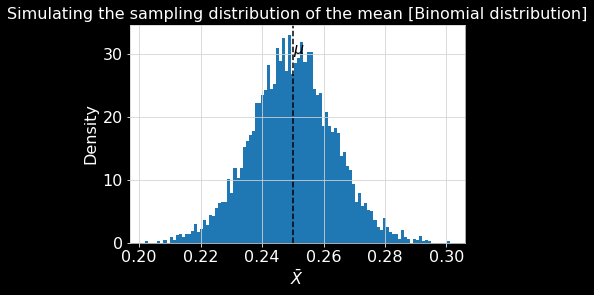

In [63]:
ax = sample_means_binomial.hist(bins=100, density=True)

# Add a vertical marker line and labels
# This time we will graph the mean of the probability distribution.
ax.axvline(1*p, color='black', linestyle='--')
ax.text(x=(1*p), y=30, s=r'$\mu$', fontsize=16)
ax.set_xlabel(r'$\bar{X}$', fontsize=16)
ax.set_ylabel('Density', fontsize=16)
ax.set_title("Simulating the sampling distribution of the mean [Binomial distribution]", fontsize=16, color = 'white')
ax.tick_params(labelsize=16)


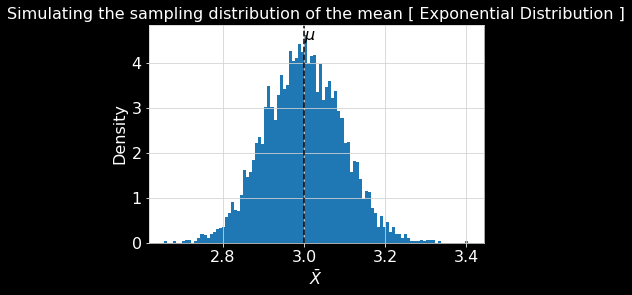

In [65]:
ax = sample_means_exponential.hist(bins=100, density=True)
scale = 3
# Add a vertical marker line and labels
# This time we will graph the mean of the probability distribution.
ax.axvline(scale, color='black', linestyle='--')
ax.text(x=(scale), y=4.5, s=r'$\mu$', fontsize=16)
ax.set_xlabel(r'$\bar{X}$', fontsize=16)
ax.set_ylabel('Density', fontsize=16)
ax.set_title("Simulating the sampling distribution of the mean [ Exponential Distribution ]", fontsize=16, color ='white')

ax.tick_params(labelsize=16)

# 1.2 

## 1)


In [66]:
def draw_one_sample_two_groups(ATE, mu, sigma, n, share_treatment):
    """Randomly generate one dataset of size n.
    
    args:
    ATE: The true average treatment effect
    expectation_Y0: The average of the outcome when there is no treatment, E[Y^0]
    N: The total sample size
    share_treatment: The proportion of N in the treatment group
    
    """
    units = np.arange(0, n)
    treatment_units = np.random.choice(units, int(len(units) * share_treatment), replace=False)
    df = pd.DataFrame({'i': units})
    # Set the treatment units to have d_i = 1
    df['d'] = df['i'].isin(treatment_units).astype('float')
    # The outcome of interest is Y. 
    # Let's make the treatment give a boost of 0.5!
    # The ATE will be 0.5!
    Yi = np.random.normal(loc=mu + ATE * df['d'], scale=sigma, size=n)
    df['y'] = Yi
    return df

  
def get_difference_in_means(df):
    # Calculate means by each group. Then take the difference.
    means = df.groupby('d')['y'].mean()
    diff = means.loc[1] - means.loc[0]

    N = df.shape[0]
    N_treatment = df['d'].sum()
    
    return {
        'N': N,
        'N_treatment': N_treatment,
        'mean_treatment': means.loc[1],
        'mean_control': means.loc[0],
        'diff': diff
    }

In [121]:
mu = 1
sigma = 2

b = 5000  # Total number of *samples* to generate
n = 1000  # The number of data points in each sample

share_treatment = 0.5

ATE = 0.5
list_of_samples = [draw_one_sample_two_groups(ATE=ATE, mu=mu, sigma=sigma, n=n, share_treatment=share_treatment) for _ in tqdm_notebook(range(0, b))]
sample_results = pd.DataFrame([get_difference_in_means(sample) for sample in tqdm_notebook(list_of_samples)])

assert((sample_results['N'] == n).all())
assert((sample_results['N_treatment'] == int(n * share_treatment)).all())

count    5000.000000
mean        0.500370
std         0.128181
min         0.066013
25%         0.415241
50%         0.500440
75%         0.585504
max         0.967540
Name: diff, dtype: float64


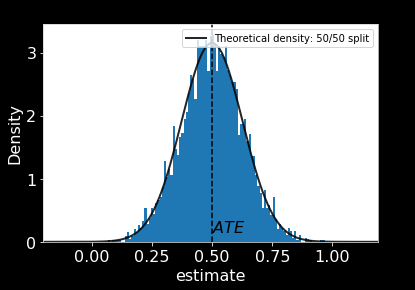

In [122]:
ax = sample_results['diff'].hist(bins=100, density=True)

# Normal PDF assuming equally-sized treatment and control groups
normal_pdf = partial(scipy.stats.norm.pdf, loc=0.5, scale=(sigma * np.sqrt((2/n) + 2/n)))
grid_of_x_values = np.arange(-0.20, 1.2, 0.01)
pdf = pd.DataFrame({'x': grid_of_x_values})
pdf['fx'] = pdf['x'].apply(normal_pdf)
pdf.plot(x='x', y='fx', ax=ax, linewidth=2, alpha=0.85, color='black', label=r'Theoretical density: 50/50 split')


# Add a vertical marker line and labels
# This time we will graph the mean of the probability distribution.
ax.axvline(ATE, color='black', linestyle='--')
ax.text(x=ATE, y=pdf['fx'].max()*0.05, s=r'$ATE$', fontsize=16)
ax.set_xlabel('estimate', fontsize=16)
ax.set_ylabel('Density', fontsize=16)
ax.set_title("Simulating the sampling distribution of the mean", fontsize=16)
ax.legend(fontsize=10)
ax.tick_params(labelsize=16)

print(sample_results['diff'].describe())


In [140]:
std = sample_results['diff'].std()

In [141]:
print('Probability( ATE > 0.7):',len(sample_results[sample_results['diff'] > 0.7]) / len(sample_results['diff']))
print('Probability 2 std away from true ATE:',len(sample_results[(sample_results['diff'] > (0.5 + 2*std)) | (sample_results['diff'] < (0.5 -2*std))])/len(sample_results))

Probability( ATE > 0.7): 0.058
Probability 2 std away from true ATE: 0.0496


In [ ]:
sample_results[sample_results['diff'] > (0.5 + 2*std)]

## 2)

In [104]:
mu = 1
sigma = 2

b = 5000  # Total number of *samples* to generate
n = 1000  # The number of data points in each sample

share_treatment = 0.2

ATE = 0.5
list_of_samples = [draw_one_sample_two_groups(ATE=ATE, mu=mu, sigma=sigma, n=n, share_treatment=share_treatment) for _ in tqdm_notebook(range(0, b))]
sample_results = pd.DataFrame([get_difference_in_means(sample) for sample in tqdm_notebook(list_of_samples)])

assert((sample_results['N'] == n).all())
assert((sample_results['N_treatment'] == int(n * share_treatment)).all())

count    5000.000000
mean        0.502288
std         0.156147
min        -0.078318
25%         0.399252
50%         0.504740
75%         0.606095
max         1.050902
Name: diff, dtype: float64


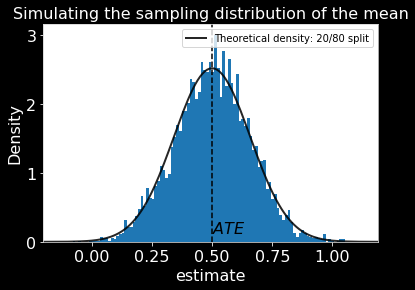

In [120]:
ax = sample_results['diff'].hist(bins=100, density=True)

# Normal PDF assuming unequally-sized treatment and control groups
normal_pdf = partial(scipy.stats.norm.pdf, loc=0.5, scale=(sigma * np.sqrt((1/(0.2*n)) + 1/(0.8*n))))
grid_of_x_values = np.arange(-0.20, 1.2, 0.01)
pdf = pd.DataFrame({'x': grid_of_x_values})
pdf['fx'] = pdf['x'].apply(normal_pdf)
pdf.plot(x='x', y='fx', ax=ax, linewidth=2, alpha=0.85, color='black', label=r'Theoretical density: 20/80 split')


# Add a vertical marker line and labels
# This time we will graph the mean of the probability distribution.
ax.axvline(ATE, color='black', linestyle='--')
ax.text(x=ATE, y=pdf['fx'].max()*0.05, s=r'$ATE$', fontsize=16)
ax.set_xlabel('estimate', fontsize=16)
ax.set_ylabel('Density', fontsize=16)
ax.set_title("Simulating the sampling distribution of the mean", fontsize=16, color = 'white')
ax.legend(fontsize=10)
ax.tick_params(labelsize=16)

print(sample_results['diff'].describe())


In [106]:
sample_results['diff'].std()

0.15614705845574503

Probability( ATE > 0.7): 0.1008


# ii)

In [93]:
control_sample_mean = [i.groupby('d')['y'].mean()[0] for i in list_of_samples]
control_sample_mean = pd.Series(control_sample_mean)
treatment_sample_mean = [i.groupby('d')['y'].mean()[1] for i in list_of_samples]
treatment_sample_mean = pd.Series(treatment_sample_mean)

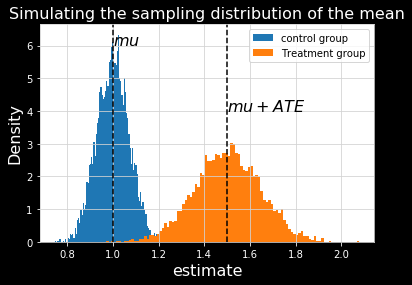

In [103]:
ax = control_sample_mean.hist(bins = 100, density = True, label = 'control group')
treatment_sample_mean.hist(bins = 100, density = True, ax= ax, label = 'Treatment group')
ax.axvline(mu, color = 'black', linestyle = '--')
ax.axvline(mu + ATE, color = 'black', linestyle = '--')
ax.set_xlabel('estimate', fontsize=16)
ax.set_ylabel('Density', fontsize=16)
ax.set_title("Simulating the sampling distribution of the mean", fontsize=16, color = 'white')
ax.text(x=mu, y=6, s=r'$mu$', fontsize=16)
ax.text(x=mu+ATE, y=4, s=r'$mu+ATE$', fontsize=16)
ax.legend()

# 2.

## 2)

In [146]:
def get_difference_in_means_with_ttest(df, alpha):
    # Calculate means by each group. Then take the difference and do a t-test.
    means = df.groupby('d')['y'].mean()
    diff = means.loc[1] - means.loc[0]

    N = df.shape[0]
    N_treatment = df['d'].sum()
    ttest_results = get_ttest_analysis(df)
    reject_null = (ttest_results['p'] < alpha).astype('float')
    
    return {
        'N': N,
        'N_treatment': N_treatment,
        'mean_treatment': means.loc[1],
        'mean_control': means.loc[0],
        'diff': diff,
        't': ttest_results['t'],
        'p': ttest_results['p'],
        'reject_null': reject_null
    }

def get_simulation_results(expectation_Y0, ATE, share_treatment, n, B, sigma, alpha):
  params = dict(ATE=ATE, mu=expectation_Y0, n=n, share_treatment=share_treatment, sigma=sigma)
  list_of_samples = [draw_one_sample_two_groups(**params) for _ in tqdm_notebook(range(0, B))]
  simulations = pd.DataFrame([get_difference_in_means_with_ttest(sample, alpha) for sample in tqdm_notebook(list_of_samples)])
  
  # Return a summary of the simulations and the specified paramters.
  return {
      'diff_mean': simulations['diff'].mean(),
      'diff_std': simulations['diff'].std(),
      't_mean': simulations['t'].mean(),
      't_std': simulations['t'].std(),
      'alpha': alpha,
      'p_reject': simulations['reject_null'].mean(),
      'B': B,
      'N': simulations['N'].mean(),
      'N_treatment': simulations['N_treatment'].mean(),
      'share_treatment': share_treatment,
      'expectation_Y0': expectation_Y0,
      'sigma': sigma,
      'ATE': ATE
  }

def get_ttest_analysis(df):    
    # A slower way to do this:
    treatment_group =  (df['d'] == 1)
    #diff = df.loc[treatment_group, 'y'].mean() - df.loc[~treatment_group, 'y'].mean()
    results = scipy.stats.ttest_ind(
        df.loc[treatment_group, 'y'], 
        df.loc[~treatment_group, 'y'])
    return {'t': results.statistic, 'p': results.pvalue}

In [147]:
# Simulation results over a grid of parameter values
B = 5000
ATE = 0.0
parameter_grid = [
    dict(B = B, n = 1000, expectation_Y0 = 3, ATE = ATE, share_treatment = 0.10, sigma = 1, alpha = 0.05),
    dict(B = B, n = 1000, expectation_Y0 = 3, ATE = ATE, share_treatment = 0.25, sigma = 1, alpha = 0.05),
    dict(B = B, n = 1000, expectation_Y0 = 3, ATE = ATE, share_treatment = 0.50, sigma = 1, alpha = 0.05),
    dict(B = B, n = 1000, expectation_Y0 = 3, ATE = ATE, share_treatment = 0.75, sigma = 1, alpha = 0.05),
    dict(B = B, n = 1000, expectation_Y0 = 3, ATE = ATE, share_treatment = 0.90, sigma = 1, alpha = 0.05),
]

simulation_results =  pd.DataFrame([get_simulation_results(**params) for params in parameter_grid])

# We can also test that the simulations worked as expected.
# For example:
assert((simulation_results['share_treatment'] == simulation_results.eval("N_treatment / N")).all())

In [148]:

simulation_results

,diff_mean,diff_std,t_mean,t_std,alpha,p_reject,B,N,N_treatment,share_treatment,expectation_Y0,sigma,ATE
0,-0.002376,0.104162,-0.022893,0.988910,0.05,0.0448,5000,1000.0,100.0,0.10,3,1,0.0
1,0.001047,0.073026,0.013998,1.001174,0.05,0.0480,5000,1000.0,250.0,0.25,3,1,0.0
2,-0.000546,0.062983,-0.008386,0.997150,0.05,0.0492,5000,1000.0,500.0,0.50,3,1,0.0
3,-0.000269,0.072756,-0.003446,0.997711,0.05,0.0510,5000,1000.0,750.0,0.75,3,1,0.0
4,0.001103,0.106948,0.010008,1.016032,0.05,0.0542,5000,1000.0,900.0,0.90,3,1,0.0


In [265]:
def dist_plot(mu,sigma,label):
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    ax = plt.gca()
    ax.plot(x, scipy.stats.norm.pdf(x, mu, sigma),label = label)
    ax.legend()

[None, None, None, None, None]

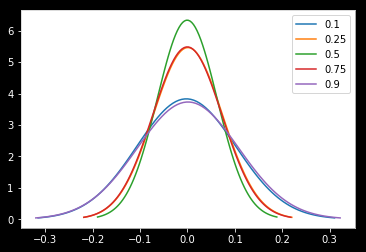

In [266]:
[dist_plot(simulation_results['diff_mean'].loc[i],simulation_results['diff_std'].loc[i], simulation_results['share_treatment'].loc[i]) for i in range(0,5)]

[None, None, None, None, None]

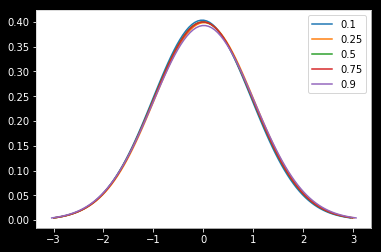

In [267]:
[dist_plot(simulation_results['t_mean'].loc[i],simulation_results['t_std'].loc[i], simulation_results['share_treatment'].loc[i]) for i in range(0,5)]

Text(0.5, 1.0, 'share_treatment Vs.p_reject')

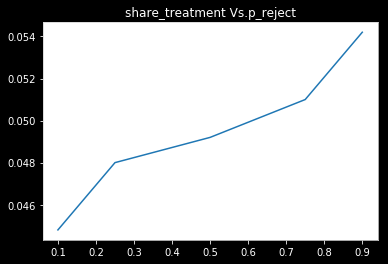

In [272]:
plt.plot(simulation_results['share_treatment'],simulation_results['p_reject'])
plt.title("share_treatment Vs.p_reject", color ='white')

## 3)

In [273]:
# Simulation results over a grid of parameter values
B = 5000
ATE = 0.0
parameter_grid = [
    dict(B = B, n = 100, expectation_Y0 = 3, ATE = ATE, share_treatment = 0.50, sigma = 1, alpha = 0.05),
    dict(B = B, n = 1000, expectation_Y0 = 3, ATE = ATE, share_treatment = 0.50, sigma = 1, alpha = 0.05),
    dict(B = B, n = 10000, expectation_Y0 = 3, ATE = ATE, share_treatment = 0.50, sigma = 1, alpha = 0.05)
]

simulation_results =  pd.DataFrame([get_simulation_results(**params) for params in parameter_grid])

# We can also test that the simulations worked as expected.
# For example:
assert((simulation_results['share_treatment'] == simulation_results.eval("N_treatment / N")).all())

In [285]:
simulation_results

,diff_mean,diff_std,t_mean,t_std,alpha,p_reject,B,N,N_treatment,share_treatment,expectation_Y0,sigma,ATE
0,-0.000677,0.201722,-0.003007,1.017609,0.05,0.0510,5000,100.0,50.0,0.5,3,1,0.0
1,0.000614,0.065166,0.010003,1.032119,0.05,0.0616,5000,1000.0,500.0,0.5,3,1,0.0
2,-0.000456,0.019842,-0.022869,0.992018,0.05,0.0474,5000,10000.0,5000.0,0.5,3,1,0.0


Text(0.5, 1.0, 'Distribution of diff')

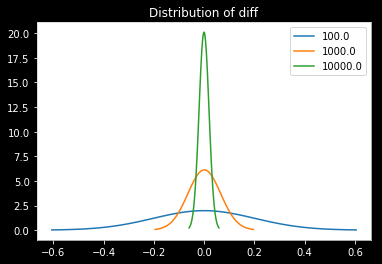

In [282]:
[dist_plot(simulation_results['diff_mean'].loc[i],simulation_results['diff_std'].loc[i], simulation_results['N'].loc[i]) for i in range(0,len(parameter_grid))]
plt.gca().set_title("Distribution of diff",color = 'white')

Text(0.5, 1.0, 'Distribution of t')

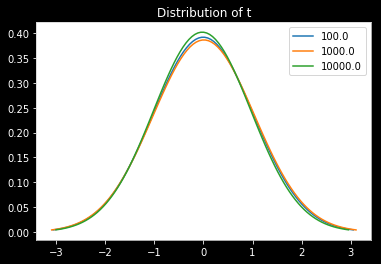

In [283]:
[dist_plot(simulation_results['t_mean'].loc[i],simulation_results['t_std'].loc[i], simulation_results['N'].loc[i]) for i in range(0,len(parameter_grid))]
plt.gca().set_title("Distribution of t",color = 'white')

Text(0.5, 1.0, 'N Vs.p_reject')

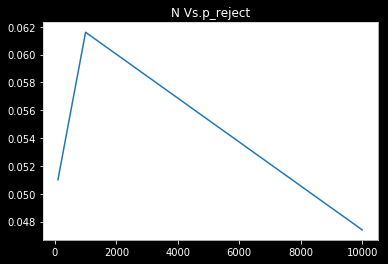

In [284]:
plt.plot(simulation_results['N'],simulation_results['p_reject'])
plt.title("N Vs.p_reject", color ='white')

## 4)

In [286]:
B = 5000
ATE = 0.0
parameter_grid = [
    dict(B = B, n = 1000, expectation_Y0 = 10, ATE = ATE, share_treatment = 0.50, sigma = 20, alpha = 0.05)
]

simulation_results =  pd.DataFrame([get_simulation_results(**params) for params in parameter_grid])

# We can also test that the simulations worked as expected.
# For example:
assert((simulation_results['share_treatment'] == simulation_results.eval("N_treatment / N")).all())

In [287]:
simulation_results

,diff_mean,diff_std,t_mean,t_std,alpha,p_reject,B,N,N_treatment,share_treatment,expectation_Y0,sigma,ATE
0,0.011378,1.260418,0.009133,0.996432,0.05,0.0458,5000,1000.0,500.0,0.5,10,20,0.0


## 5)

In [288]:
# Simulation results over a grid of parameter values
B = 5000
ATE = 0.0
parameter_grid = [
    dict(B = B, n = 100, expectation_Y0 = 3, ATE = ATE, share_treatment = 0.50, sigma = 1, alpha = 0.1),
    dict(B = B, n = 1000, expectation_Y0 = 3, ATE = ATE, share_treatment = 0.50, sigma = 1, alpha = 0.1),
    dict(B = B, n = 10000, expectation_Y0 = 3, ATE = ATE, share_treatment = 0.50, sigma = 1, alpha = 0.1)
]

simulation_results =  pd.DataFrame([get_simulation_results(**params) for params in parameter_grid])

# We can also test that the simulations worked as expected.
# For example:
assert((simulation_results['share_treatment'] == simulation_results.eval("N_treatment / N")).all())

In [289]:
simulation_results

,diff_mean,diff_std,t_mean,t_std,alpha,p_reject,B,N,N_treatment,share_treatment,expectation_Y0,sigma,ATE
0,0.004392,0.201687,0.022298,1.019268,0.1,0.1004,5000,100.0,50.0,0.5,3,1,0.0
1,0.001614,0.062770,0.024996,0.993008,0.1,0.0952,5000,1000.0,500.0,0.5,3,1,0.0
2,-0.000051,0.019967,-0.002634,0.998443,0.1,0.1008,5000,10000.0,5000.0,0.5,3,1,0.0


## 6)


In [290]:
# Simulation results over a grid of parameter values
B = 5000
ATE = 0.15
parameter_grid = [
    dict(B = B, n = 1000, expectation_Y0 = 3, ATE = ATE, share_treatment = 0.50, sigma = 1, alpha = 0.01),
    dict(B = B, n = 1000, expectation_Y0 = 3, ATE = ATE, share_treatment = 0.50, sigma = 1, alpha = 0.05),
    dict(B = B, n = 1000, expectation_Y0 = 3, ATE = ATE, share_treatment = 0.50, sigma = 1, alpha = 0.1),
    dict(B = B, n = 1000, expectation_Y0 = 3, ATE = ATE, share_treatment = 0.50, sigma = 1, alpha = 0.15),
    dict(B = B, n = 1000, expectation_Y0 = 3, ATE = ATE, share_treatment = 0.50, sigma = 1, alpha = 0.25),
    dict(B = B, n = 1000, expectation_Y0 = 3, ATE = ATE, share_treatment = 0.50, sigma = 1, alpha = 0.35)
]

simulation_results =  pd.DataFrame([get_simulation_results(**params) for params in parameter_grid])

# We can also test that the simulations worked as expected.
# For example:
assert((simulation_results['share_treatment'] == simulation_results.eval("N_treatment / N")).all())

In [294]:
simulation_results[['alpha','p_reject']]

,alpha,p_reject
0,0.01,0.4188
1,0.05,0.6616
2,0.10,0.7720
3,0.15,0.8204
4,0.25,0.8922
5,0.35,0.9224


Text(0.5, 1.0, 'Power Vs. Alpha')

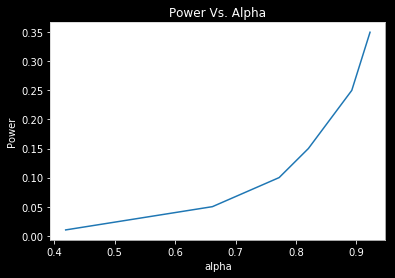

In [303]:
plt.plot(simulation_results['p_reject'], simulation_results['alpha'])
plt.gca().set_ylabel('Power')
plt.gca().set_xlabel('alpha')
plt.title('Power Vs. Alpha', color = 'white')

## 3)


In [305]:
# Simulation results over a grid of parameter values
B = 5000
ATE = 0.15
parameter_grid = [
    dict(B = B, n = 1000, expectation_Y0 = 3, ATE = ATE, share_treatment = 0.10, sigma = 1, alpha = 0.05),
    dict(B = B, n = 1000, expectation_Y0 = 3, ATE = ATE, share_treatment = 0.25, sigma = 1, alpha = 0.05),
    dict(B = B, n = 1000, expectation_Y0 = 3, ATE = ATE, share_treatment = 0.50, sigma = 1, alpha = 0.05),
    dict(B = B, n = 1000, expectation_Y0 = 3, ATE = ATE, share_treatment = 0.75, sigma = 1, alpha = 0.05),
    dict(B = B, n = 1000, expectation_Y0 = 3, ATE = ATE, share_treatment = 0.90, sigma = 1, alpha = 0.05),
]

simulation_results =  pd.DataFrame([get_simulation_results(**params) for params in parameter_grid])

# We can also test that the simulations worked as expected.
# For example:
assert((simulation_results['share_treatment'] == simulation_results.eval("N_treatment / N")).all())

In [308]:
simulation_results[['share_treatment','p_reject']]

,share_treatment,p_reject
0,0.10,0.3034
1,0.25,0.5330
2,0.50,0.6608
3,0.75,0.5304
4,0.90,0.2950


Text(0.5, 1.0, 'Power Vs. Share treatment')

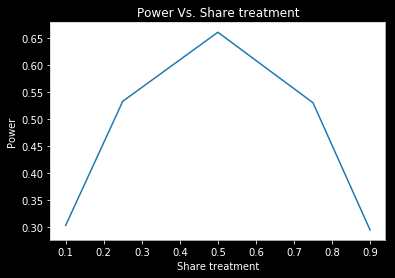

In [309]:
plt.plot(simulation_results['share_treatment'],simulation_results['p_reject'])
plt.gca().set_ylabel('Power')
plt.gca().set_xlabel('Share treatment')
plt.title('Power Vs. Share treatment', color = 'white')

## 5)

### i)

In [310]:
# Set up functions that calculate power as a function of sample size.
ATE = 0.15
alpha = 0.05
sigma = 1

def power_function(nobs1):
    """Calculate power for the given sample size.
    
    Assumes that treatment and control groups are the same size.
    Assumes that the effect_size is ATE / sigma.
    Assumes that alpha (test size) is alpha.
    args:
    nobs1: The sample size of one group.
    """
    return power.tt_ind_solve_power( 
        effect_size=ATE / sigma,
        nobs1=nobs1,
        alpha=alpha,
        ratio=1.0  # ratio of sample sizes in treatment group vs. control group
    )


In [312]:
power_function(500)

0.6589069549458351

## BONUS

## 1.

In [367]:
# Set up functions that calculate power as a function of sample size.
ATE = 0.15
alpha = 0.05
sigma = 1

def power_function(nobs1):
    """Calculate power for the given sample size.
    
    Assumes that treatment and control groups are the same size.
    Assumes that the effect_size is ATE / sigma.
    Assumes that alpha (test size) is alpha.
    args:
    nobs1: The sample size of one group.
    """
    return power.tt_ind_solve_power( 
        effect_size=ATE / sigma,
        nobs1=nobs1,
        alpha=alpha,
        ratio=9  # ratio of sample sizes in treatment group vs. control group
    )


In [376]:
power_function(390)

0.8022251248655252

### ii)

In [377]:
# Set up functions that calculate power as a function of sample size.
ATE = 0.15
alpha = 0.01
sigma = 1

def power_function(nobs1):
    """Calculate power for the given sample size.
    
    Assumes that treatment and control groups are the same size.
    Assumes that the effect_size is ATE / sigma.
    Assumes that alpha (test size) is alpha.
    args:
    nobs1: The sample size of one group.
    """
    return power.tt_ind_solve_power( 
        effect_size=ATE / sigma,
        nobs1=nobs1,
        alpha=alpha,
        ratio=9  # ratio of sample sizes in treatment group vs. control group
    )


In [385]:
power_function(580)

0.8024175210665379